In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from shutil import copy2
import csv

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install tensorflow_hub

In [5]:
import tensorflow_hub as hub

In [6]:
tf.__version__

'2.4.0'

In [7]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [8]:
data_root = ("/content/drive/MyDrive/PokerImages/Dataset")

In [9]:


IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)



Found 49 images belonging to 5 classes.
Found 202 images belonging to 5 classes.


In [10]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 5))

In [11]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Black': 0, 'Blue': 1, 'Green': 2, 'Red': 3, 'White': 4}


In [12]:
!cat labels.txt

Black
Blue
Green
Red
White

In [13]:
IMAGE_SIZE = 224

In [14]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [16]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [18]:


steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=100,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history



Epoch 1/100
7/7 [==============================] - 81s 13s/step - loss: 1.5280 - acc: 0.3416 - val_loss: 1.1815 - val_acc: 0.4694
Epoch 2/100
7/7 [==============================] - 39s 6s/step - loss: 1.1874 - acc: 0.5347 - val_loss: 0.9643 - val_acc: 0.6939
Epoch 3/100
7/7 [==============================] - 40s 6s/step - loss: 0.9668 - acc: 0.6287 - val_loss: 0.8384 - val_acc: 0.7551
Epoch 4/100
7/7 [==============================] - 39s 6s/step - loss: 0.7655 - acc: 0.7376 - val_loss: 0.7457 - val_acc: 0.7347
Epoch 5/100
7/7 [==============================] - 39s 6s/step - loss: 0.6225 - acc: 0.8020 - val_loss: 0.6671 - val_acc: 0.8367
Epoch 6/100
7/7 [==============================] - 39s 6s/step - loss: 0.5713 - acc: 0.8069 - val_loss: 0.6366 - val_acc: 0.7755
Epoch 7/100
7/7 [==============================] - 39s 6s/step - loss: 0.4132 - acc: 0.8713 - val_loss: 0.5760 - val_acc: 0.7959
Epoch 8/100
7/7 [==============================] - 39s 6s/step - loss: 0.4302 - acc: 0.8614 - va

In [19]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 8s 3s/step - loss: 0.2151 - acc: 0.9184
Final loss: 0.22
Final accuracy: 91.84%


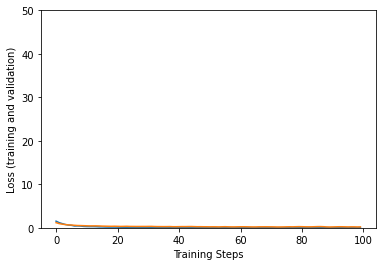

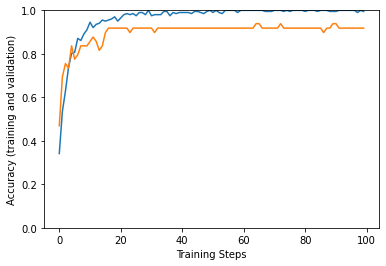

In [20]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [21]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [22]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Black' 'Blue' 'Green' 'Red' 'White']


In [23]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 5)


In [24]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Black' 'Black' 'Red' 'Green' 'White' 'Black' 'White' 'Black' 'Red'
 'White' 'Green' 'Green' 'White' 'Blue' 'Red' 'Green' 'Blue' 'Red' 'Blue'
 'Red' 'Blue' 'Green' 'White' 'Green' 'Green' 'Black' 'Green' 'Green'
 'Blue' 'Red' 'Black' 'Black']


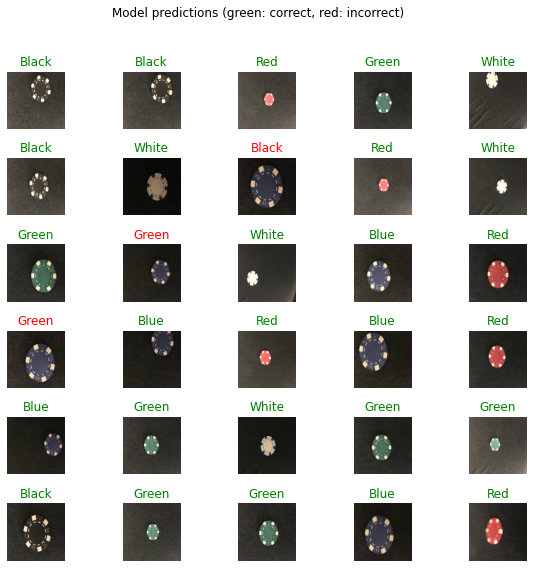

In [25]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")